In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import csv

## Reading

In [4]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 150

In [5]:
row_start = 14

In [6]:
metadata = dict()
filename = "2A.CSV"
with open(filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '0.001',
 'Sample Interval': '8e-08',
 'Filter Frequency': '2e+08',
 'Record Length': '125000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '2',
 'Label': ''}

In [7]:
data = pd.read_csv(filename, delimiter=",", header=row_start)
data

,TIME,CH1,CH1 Peak Detect,CH2,CH2 Peak Detect
0,-0.00078,-0.08,-7.152560e-09,-1.341100e-10,0.004
1,-0.00078,-0.08,-8.000000e-02,-1.341100e-10,-0.002
2,-0.00078,-0.08,-7.152560e-09,-2.000000e-03,0.004
3,-0.00078,-0.08,-8.000000e-02,2.000000e-03,-0.004
4,-0.00078,-0.08,-7.152560e-09,-1.341100e-10,0.006
...,...,...,...,...,...
124995,0.00922,3.92,3.840000e+00,-1.341100e-10,-0.006
124996,0.00922,3.92,4.000000e+00,-1.341100e-10,0.006
124997,0.00922,3.92,3.840000e+00,-1.341100e-10,-0.004
124998,0.00922,3.92,4.000000e+00,-1.341100e-10,0.004


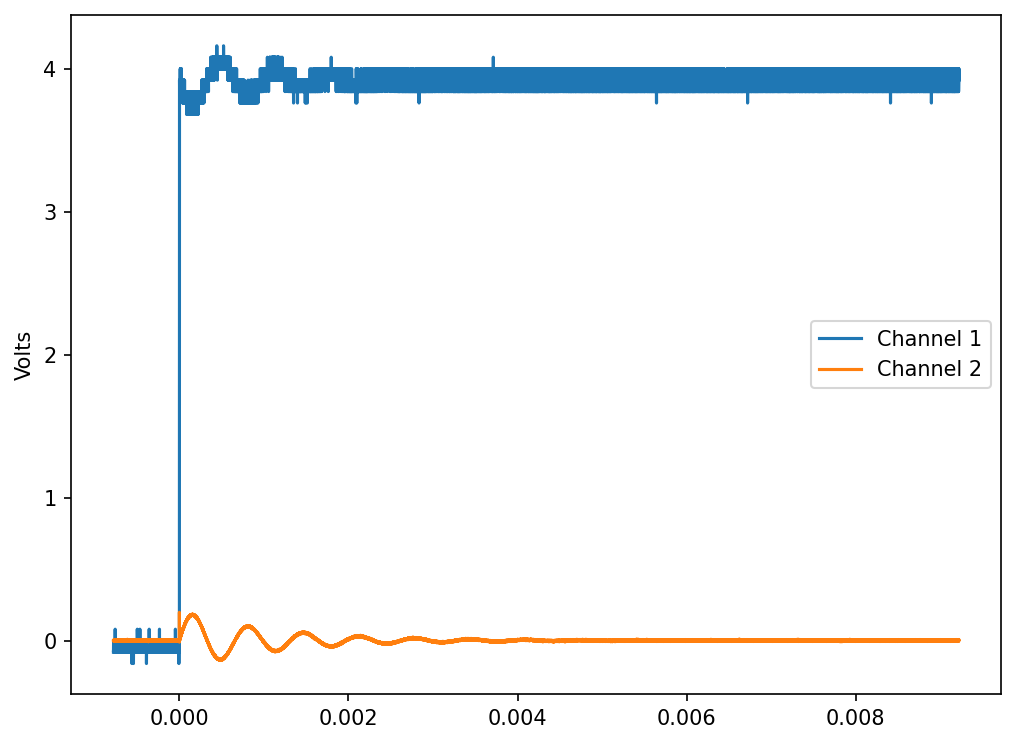

In [8]:
t_raw = data["TIME"].to_numpy()
ch1_raw = data["CH1"].to_numpy()
ch2_raw = data["CH2"].to_numpy()
plt.plot(
    t_raw, 
    ch1_raw,
    label="Channel 1"
)
plt.plot(
    t_raw, 
    ch2_raw,
    label="Channel 2"
)
plt.ylabel("Volts")
plt.legend()

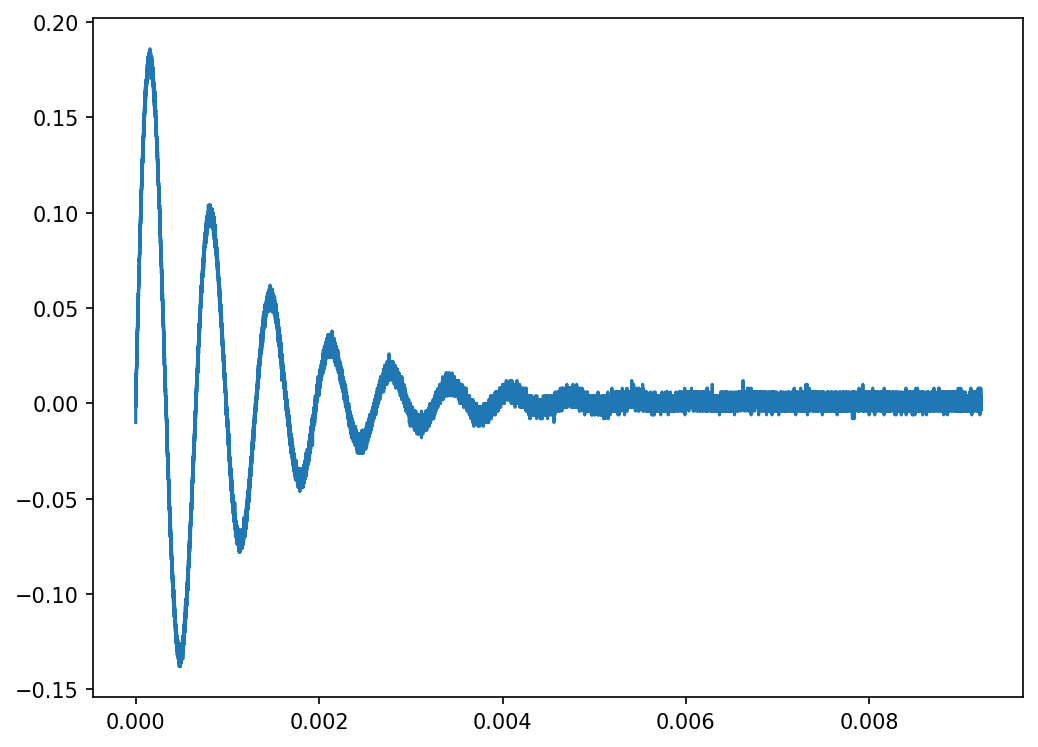

In [10]:
t = t_raw[ch1_raw > 1][1:]
ch2_noisy = ch2_raw[ch1_raw > 1][1:]
plt.plot(t, ch2_noisy)

In [11]:
from scipy import signal

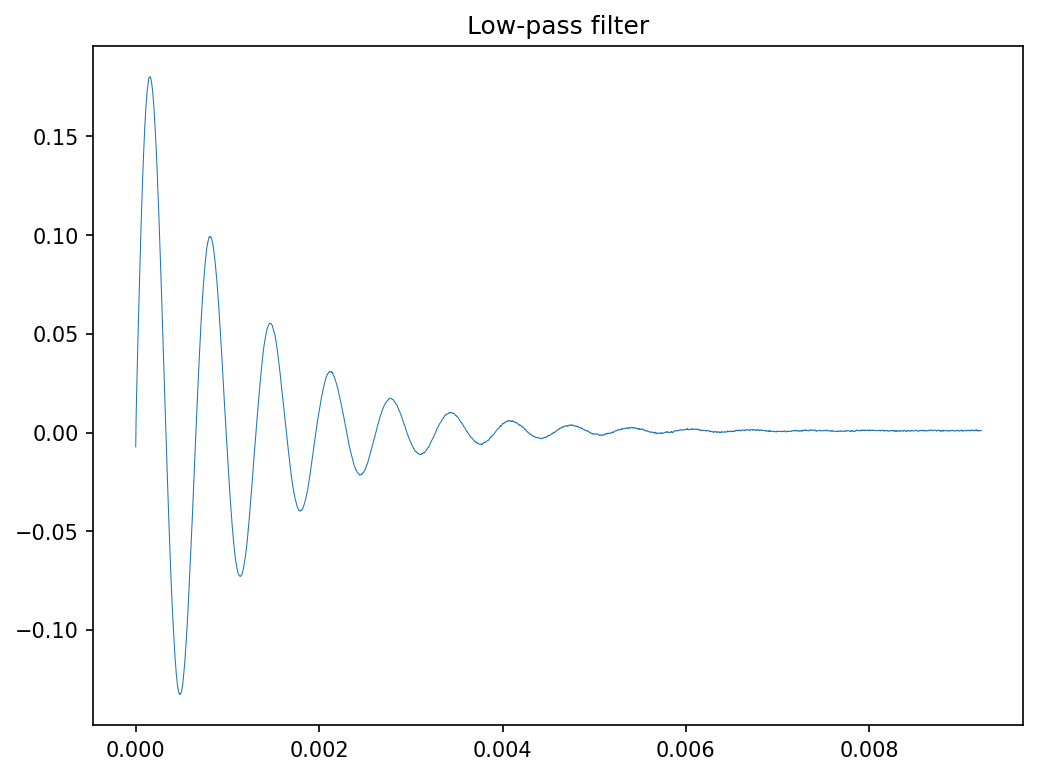

In [12]:
sample_frequency = 2e8
cutoff_frequency = 1e6
b, a = signal.butter(1, 2*cutoff_frequency/sample_frequency)
ch2 = signal.filtfilt(b, a, ch2_noisy)
plt.plot(t, ch2, lw=0.5)
plt.title("Low-pass filter")
plt.show()

## Fourier transform

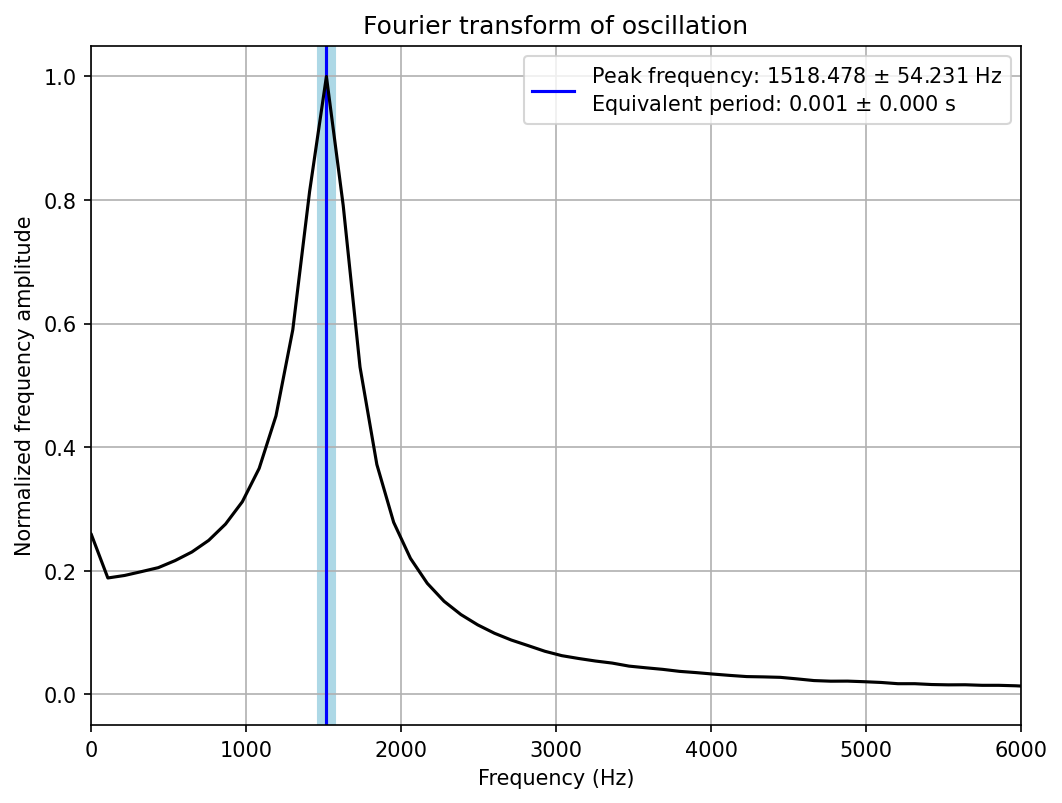

In [13]:
from scipy.fft import fft, fftfreq, fftshift

spectrum = np.abs(fftshift(fft(ch2)))
spectrum /= np.max(spectrum)
sampling_rate = 1 / np.average(np.diff(t))
freq = fftshift(fftfreq(t.size, 1/sampling_rate))
bin_width = np.average(np.diff(freq))

maxfreq = np.average(np.abs(freq[np.where(spectrum == np.max(spectrum))]))
leftfreq = maxfreq - bin_width/2
rightfreq = maxfreq + bin_width/2
plt.axvline(maxfreq, color="blue", 
            label=f"""Peak frequency: {maxfreq:.3f} $\pm$ {bin_width/2:.3f} Hz
Equivalent period: {1/maxfreq:.3f} $\pm$ {1/leftfreq - 1/rightfreq:.3f} s""")
plt.axvspan(
    leftfreq, 
    rightfreq, 
    color="lightblue")

plt.title("Fourier transform of oscillation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized frequency amplitude")
plt.xlim(0, 6000)
# plt.ylim(0, 1.1)
plt.plot(freq, spectrum, color="black")
plt.grid()
plt.legend()
plt.show()

## Modeling

In [29]:
model = lambda t, A, alpha, omega, phi, b: A * np.exp(-alpha*t) * np.cos(omega*t - phi) + b
[A_model, alpha_model, omega_model, phi_model, b_model], cov = (
    sp.optimize.curve_fit(model, t, ch2, p0=[0.2, 900, 10000, 1.5, 0])
)
omega_model/2/np.pi, cov

(1524.3763883197496,
 array([[ 4.75160323e-11,  2.10031463e-07,  3.56443594e-08,
          4.02508446e-11, -5.06030628e-13],
        [ 2.10031463e-07,  1.77074703e-03,  1.54802404e-04,
          1.75613821e-07, -2.20199921e-09],
        [ 3.56443594e-08,  1.54802404e-04,  1.66943736e-03,
          9.15862376e-07,  2.16085165e-10],
        [ 4.02508446e-11,  1.75613821e-07,  9.15862376e-07,
          1.01477137e-09,  9.35348031e-15],
        [-5.06030628e-13, -2.20199921e-09,  2.16085165e-10,
          9.35348031e-15,  6.57827891e-13]]))

In [30]:
[dA_model, dAlpha_model, dOmega_model, dPhi_model, dB_model] = np.sqrt(cov.diagonal())

In [31]:
v_model = model(t, A_model, alpha_model, omega_model, phi_model, b_model)
res = ch2 - v_model

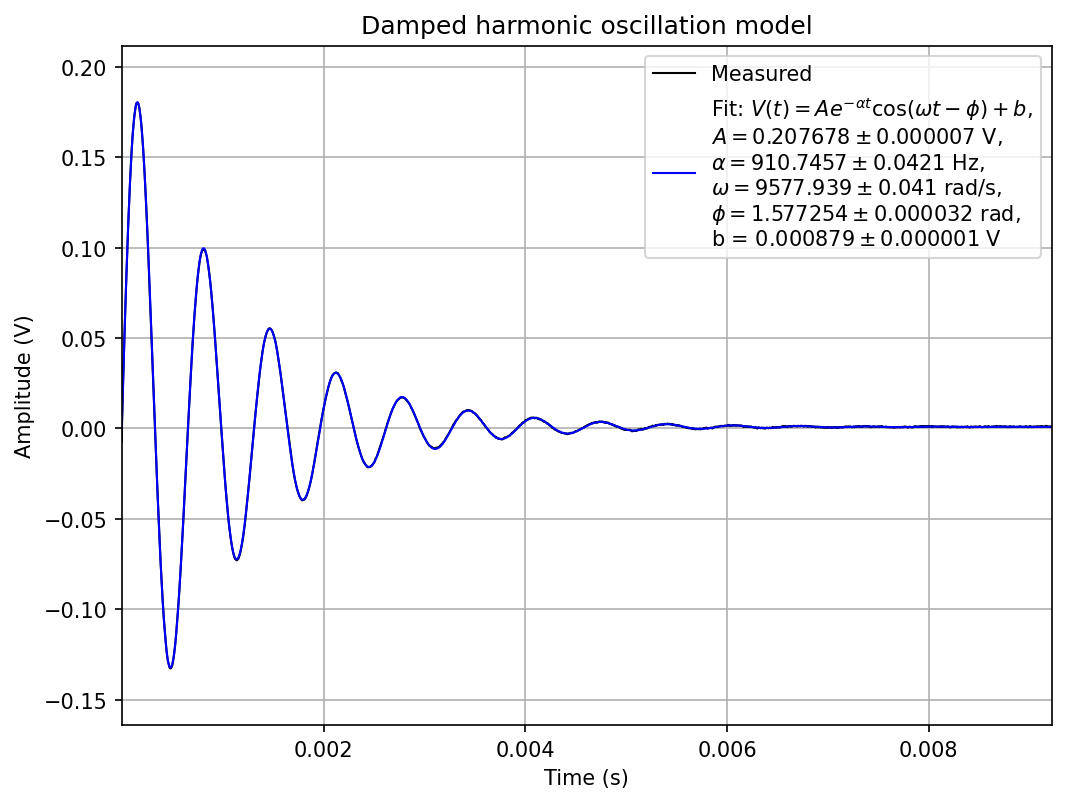

In [38]:
fit_label = "\n".join([
    r"Fit: $V(t) = A e^{-\alpha t} \cos(\omega t - \phi) + b$,",
    f"$A = {A_model:.6f} \pm {dA_model:.6f}$ V,",
    f"$\\alpha = {alpha_model:.4f} \pm {dAlpha_model:.4f}$ Hz,",
    f"$\\omega = {omega_model:.3f} \pm {dOmega_model:.3f}$ rad/s,",
    f"$\\phi = {phi_model:.6f} \pm {dPhi_model:.6f}$ rad,",
    f"b = ${b_model:.6f} \pm {dB_model:.6f}$ V",
])

plt.title("Damped harmonic oscillation model")
plt.plot(t, ch2, lw=1, color="black", label="Measured")
plt.plot(t, v_model, lw=1, color="blue", label=fit_label)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.margins(0, 0.1)
plt.grid()
plt.legend()
plt.show()

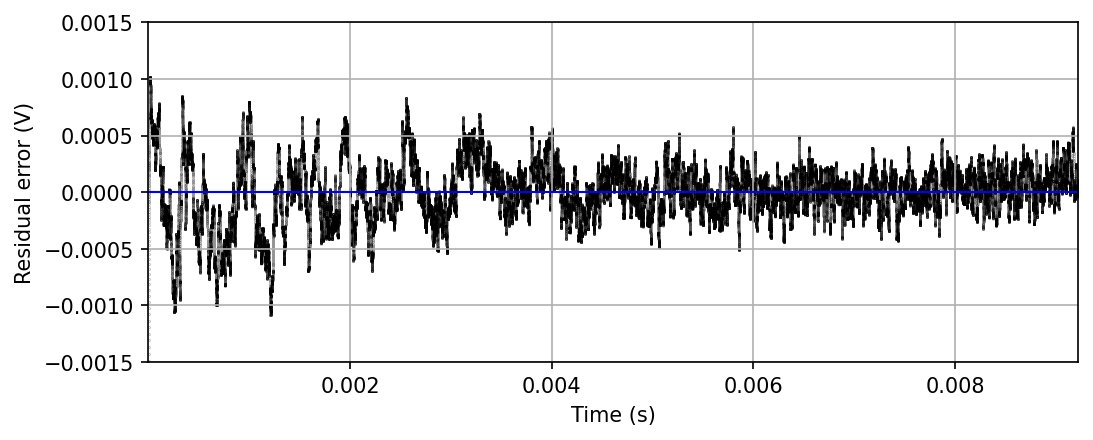

In [42]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.scatter(t, res, s=0.01, color="black")
plt.axhline(0, lw=1, color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Residual error (V)")
plt.margins(0, 0.1)
plt.ylim(-0.0015, +0.0015)
plt.grid()
plt.show()
